In [1]:
import numpy as np
from jesse import helpers, research

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles.shape)

np.save("data/btc_1m.npy", candles)

(2831040, 6)


In [1]:
import numpy as np

candles = np.load("data/btc_1m.npy")
print(candles.shape)
candles[0, 0]


(2831040, 6)


1577836800000.0

In [2]:
import os

import pandas as pd
from jesse.utils import numpy_candles_to_dataframe
from mpire import WorkerPool

from custom_indicators.toolbox.entropy.apen_sampen import sample_entropy_numba
from custom_indicators.utils.math_tools import log_ret

df = numpy_candles_to_dataframe(candles)

# label
df["label"] = np.log(df["close"].shift(-1) / df["close"])

# high low range
df["hlr"] = np.log(df["high"] / df["low"])
# df["hlr_log"] = np.log(df["hlr"] + 1)
# df["hlr_sqrt"] = np.sqrt(df["hlr"] + 1) - 1

RANGE = [5, 10, 25, 50, 75, 100, 125, 150]

# abs return
ret_list = []
for i in RANGE:
    ret_series = np.log(df["close"] / df["close"].shift(i))
    ret_series.name = f"r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list

# # log return
# log_list = []
# for i in RANGE:
#     log_series = np.log(df[f"r{i}"] + 1)
#     log_series.name = f"r{i}_log"
#     log_list.append(log_series)
#
# # sqrt return
# sqrt_list = []
# for i in RANGE:
#     sqrt_series = np.sqrt(df[f"r{i}"] + 1) - 1
#     sqrt_series.name = f"r{i}_sqrt"
#     sqrt_list.append(sqrt_series)

# entropy
entropy_list = []
for i in RANGE[2:]:
    log_ret_list = log_ret(candles, [i] * len(candles))
    with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)
    len_gap = len(df) - len(entropy_array)
    entropy_array = [np.nan] * len_gap + entropy_array
    entropy_series = pd.Series(entropy_array, index=df.index)
    entropy_series.name = f"r{i}_entropy"
    entropy_list.append(entropy_series)

df = pd.concat(
    [
        df,
        # pd.concat(log_list, axis=1),
        # pd.concat(sqrt_list, axis=1),
        pd.concat(entropy_list, axis=1),
    ],
    axis=1,
)
del entropy_list


In [3]:
# data cleaning
na_max = df.isna().sum().max()
df = df.iloc[na_max:]
del candles
print(df.shape)

print(df.isna().sum().max())
df.head()


(2830890, 22)
1


,date,open,close,high,low,volume,label,hlr,r5,r10,...,r75,r100,r125,r150,r25_entropy,r50_entropy,r75_entropy,r100_entropy,r125_entropy,r150_entropy
2020-01-01 02:30:00,2020-01-01 02:30:00,7221.59,7227.00,7227.79,7221.59,82.247,-0.000018,0.000858,0.000720,0.000969,...,0.005687,0.006817,0.007178,0.006185,0.200671,0.168884,0.090684,0.055175,0.044477,0.034509
2020-01-01 02:31:00,2020-01-01 02:31:00,7226.96,7226.87,7227.73,7223.93,118.737,-0.000143,0.000526,0.000567,0.000579,...,0.005671,0.006983,0.007284,0.006645,0.210721,0.172914,0.092568,0.057110,0.046081,0.035480
2020-01-01 02:32:00,2020-01-01 02:32:00,7226.06,7225.84,7226.13,7224.90,53.181,0.000195,0.000170,-0.000281,0.001112,...,0.005529,0.007356,0.007340,0.006652,0.270646,0.185109,0.094245,0.061849,0.049649,0.037777
2020-01-01 02:33:00,2020-01-01 02:33:00,7225.97,7227.25,7230.17,7224.78,100.884,0.000159,0.000746,-0.000199,0.000903,...,0.005724,0.007484,0.007681,0.006405,0.269920,0.193260,0.094383,0.061849,0.050010,0.038144
2020-01-01 02:34:00,2020-01-01 02:34:00,7226.88,7228.40,7228.44,7224.80,67.185,0.000112,0.000504,0.000955,0.000657,...,0.005655,0.007731,0.007783,0.007380,0.287682,0.168846,0.101039,0.063480,0.051519,0.039290


In [4]:
data_check = np.load("data/btc_1m.npy")
# hlr_check = np.abs(np.log(data_check[:, 3] / data_check[:, 4]))
# r1_check = np.abs(np.log(data_check[1:, 2] / data_check[:-1, 2]))

data_check = data_check[150:]
# hlr_check = hlr_check[149:]
# r1_check = r1_check[149 - 1 :]

# data_check = data_check[(hlr_check > 0) & (r1_check > 0)]

assert data_check.shape[0] == df.shape[0]

In [5]:
# from custom_indicators.utils.plot import find_kde_cross

# target = np.log(df["close"] / df["close"].shift(149)).dropna()
# roots = find_kde_cross(target)


In [6]:
# label = (df["abs_r1p149"] >= 1.026490246399058236).astype(int)
# label.name = "label"
# label.sort_index(inplace=True)
# label.value_counts()

In [7]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from scipy import stats

from custom_indicators.toolbox.bar.build import (
    build_bar_by_cumsum,
    build_bar_by_threshold_less_than,
)


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    MIN_LENGTH = 7500

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")
    # h1r = np.abs(np.log(candles_in_metrics[:, 3] / candles_in_metrics[:, 4]))
    # r1 = np.abs(np.log(candles_in_metrics[1:, 2] / candles_in_metrics[:-1, 2]))
    candles_in_metrics = candles_in_metrics[150:]
    # h1r = h1r[149:]
    # r1 = r1[149 - 1 :]
    # candles_in_metrics = candles_in_metrics[(h1r > 0) & (r1 > 0)]
    candles_in_metrics = candles_in_metrics[:-1]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )

    cumsum_threshold = np.sum(y_pred) / (len(candles_in_metrics) // 300)

    merged_bar_cumsum = build_bar_by_cumsum(
        candles_in_metrics,
        y_pred,
        cumsum_threshold,
        reverse=False,
    )
    log_ret_cumsum = np.log(merged_bar_cumsum[1:, 2] / merged_bar_cumsum[:-1, 2])
    std_log_ret_cumsum = (log_ret_cumsum - log_ret_cumsum.mean()) / log_ret_cumsum.std()
    kurtosis_cumsum = stats.kurtosis(std_log_ret_cumsum)

    # y_pred = 1 / (1 + np.exp(-y_pred))
    # if all(y_pred > 0.5) or all(y_pred < 0.5):
    #     return 1000
    if np.isnan(kurtosis_cumsum):
        return 1000
    return kurtosis_cumsum

    # merged_bar_1 = build_bar_by_threshold_greater_than(
    #     candles_in_metrics,
    #     y_pred,
    #     0.5,
    #     reverse=False,
    # )

    # merged_bar_2 = build_bar_by_threshold_less_than(
    #     candles_in_metrics,
    #     y_pred,
    #     0.5,
    #     reverse=False,
    # )

    # if (
    #     len(merged_bar_1) < MIN_LENGTH
    #     and len(merged_bar_2) < MIN_LENGTH
    #     and len(merged_bar_cumsum) < MIN_LENGTH
    # ):
    #     return 1000
    # elif len(merged_bar_1) < MIN_LENGTH:
    #     log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
    #     std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
    #     kurtosis_2 = stats.kurtosis(std_log_ret_2)
    #     return min(kurtosis_2, kurtosis_cumsum)
    # elif len(merged_bar_2) < MIN_LENGTH:
    #     log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
    #     std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
    #     kurtosis_1 = stats.kurtosis(std_log_ret_1)
    #     return min(kurtosis_1, kurtosis_cumsum)
    # else:
    #     log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
    #     std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
    #     kurtosis_1 = stats.kurtosis(std_log_ret_1)
    #     log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
    #     std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
    #     kurtosis_2 = stats.kurtosis(std_log_ret_2)
    #     return min(kurtosis_1, kurtosis_2, kurtosis_cumsum)


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = (
    ["hlr"]
    + [f"r{i}" for i in RANGE]
    + [f"r{i}_entropy" for i in RANGE[2:]]
)

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=12000,
    generations=20,
    tournament_size=50,
    stopping_criteria=0,
    function_set=["add", "sub", "abs", "neg", "max", "min"],
    p_crossover=0.7,
    p_subtree_mutation=0.12,
    p_hoist_mutation=0.06,
    p_point_mutation=0.12,
    max_samples=1,
    parsimony_coefficient=0.01,
    feature_names=cols,
    verbose=1,
    n_jobs=10,
    # random_state=233,
)

label = df["label"]

est_gp.fit(df[cols].iloc[:-1], label.iloc[:-1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    23.31          155.379        8          3.35954              N/A    102.28m
   1    13.72          63.8147       18          2.51842              N/A     87.81m


KeyboardInterrupt: 

In [10]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 9:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["len", "fitness"], inplace=True)
df_res


,fitness,len,program
1076,7.916345,2,r5
1516,6.379181,3,hlr
771,6.609267,7,abs(r5)
1049,5.139413,8,abs(r10)
831,6.047909,8,abs(r50)
...,...,...,...
6012,5.932207,626,"min(add(abs(add(abs(add(r150, r50)), max(max(r..."
2326,5.183736,629,"max(min(neg(add(max(max(r50, -0.697), sub(r25_..."
1927,6.067159,636,"add(min(min(min(min(max(sub(add(hlr, hlr), min..."
6754,6.324006,638,"min(add(max(add(r125, r100), abs(r100_entropy)..."


In [24]:
df_res[df_res['fitness'] < 4].sort_values('fitness')

,fitness,len,program
5895,2.698415,103,"abs(neg(sub(abs(min(0.520, r10)), min(add(max(..."
3354,2.705799,76,"abs(neg(min(add(max(-0.373, r150_entropy), add..."
5714,2.771143,113,"abs(min(min(sub(abs(r100_entropy), abs(add(r25..."
4105,2.828188,91,"abs(min(min(min(r25, r50_entropy), neg(r25)), ..."
4362,3.063217,52,"min(min(abs(r75), abs(r10)), add(r25_entropy, ..."
...,...,...,...
6852,3.979556,140,"max(abs(min(r25_entropy, r10)), add(sub(r75, r..."
5242,3.981201,110,"abs(min(min(sub(abs(r100_entropy), abs(r125)),..."
5080,3.995032,50,"abs(neg(add(min(r50_entropy, r25), add(r25, r5..."
134,3.997169,62,"abs(add(min(min(0.852, hlr), abs(r100)), neg(a..."


In [19]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 8.3821530827442: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(log_r48, max(log_r108, log_r96)))))
fitness = 8.44453781658536: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(log_r47, max(log_r108, log_r96)))))
fitness = 8.566243214459812: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(log_r42, max(abs(log_r47), max(log_r108, log_r96)))))
fitness = 8.848607123493018: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(log_r42, max(abs(log_r93), add(sqrt_r145, log_r113)))))
fitness = 8.457514040468253: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(abs(log_r47), max(log_r48, log_r96)))))
fitness = 8.575243214459812: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(abs(log_r47), max(log_r108, log_r96)))))
fitness = 8.466514040468253: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42), max(abs(abs(log_r47)), max(log_r48, log_r96)))))
fitness = 8.408509709949545: sub(abs(sub(sqrt_r33, log_r4)), sub(r42, max(abs(log_r42),

In [5]:
"""
min(abs(r25), add(r100, r50_entropy))
"""
import numpy as np
import os
from mpire import WorkerPool
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe

from custom_indicators.utils.math_tools import log_ret
from custom_indicators.toolbox.bar.entropy_bar_v2 import sample_entropy_numba

_, candles = research.get_candles(
    "Binance Perpetual Futures",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-05-20"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)
candles = candles[candles[:, 5] > 0]

print(candles.shape)

# hlr_check = np.abs(np.log(candles[:, 3] / candles[:, 4]))[1:]
# r1_check = np.abs(np.log(candles[1:, 2] / candles[:-1, 2]))
# candles = candles[1:]

# candles = candles[(hlr_check > 0) & (r1_check > 0)]

df = numpy_candles_to_dataframe(candles)
df['r25'] = np.log(df['close'] / df['close'].shift(25))
df['r100'] = np.log(df['close'] / df['close'].shift(100))
log_ret_list = log_ret(candles, [50] * len(candles))
with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
    entropy_array = pool.map(sample_entropy_numba, log_ret_list)
len_gap = len(df) - len(entropy_array)
entropy_array = [np.nan] * len_gap + entropy_array
df['r50_entropy'] = entropy_array

df['threshold'] = [min(x, y) for x, y in zip(np.abs(df['r25']).tolist(), (df['r100'] + df['r50_entropy']).tolist())]

na_max = df.isna().sum().max()
df = df.iloc[na_max:]
print(df.shape)
df.head()

(2830875, 6)
(2830775, 10)


,date,open,close,high,low,volume,r25,r100,r50_entropy,threshold
2020-01-01 01:40:00,2020-01-01 01:40:00,7210.51,7213.42,7213.42,7210.29,31.414,0.003806,0.004304,0.109267,0.003806
2020-01-01 01:41:00,2020-01-01 01:41:00,7213.42,7208.45,7213.42,7206.66,68.876,0.003119,0.004092,0.099699,0.003119
2020-01-01 01:42:00,2020-01-01 01:42:00,7209.08,7207.14,7209.08,7206.00,27.482,0.002938,0.004061,0.102452,0.002938
2020-01-01 01:43:00,2020-01-01 01:43:00,7207.14,7206.82,7208.97,7201.04,116.250,0.002893,0.003574,0.100486,0.002893
2020-01-01 01:44:00,2020-01-01 01:44:00,7207.05,7206.63,7208.12,7206.40,8.715,0.002639,0.004364,0.106005,0.002639


In [6]:
df['threshold'].sum() / (len(candles) // 300)

0.7907317146647048

In [7]:
df.tail()

,date,open,close,high,low,volume,r25,r100,r50_entropy,threshold
2025-05-19 23:55:00,2025-05-19 23:55:00,105568.2,105560.1,105583.4,105554.7,23.323,0.001098,0.002268,0.192815,0.001098
2025-05-19 23:56:00,2025-05-19 23:56:00,105560.1,105534.3,105568.3,105534.3,19.583,0.000859,0.003312,0.199333,0.000859
2025-05-19 23:57:00,2025-05-19 23:57:00,105534.3,105536.3,105536.3,105514.7,30.142,0.000507,0.002750,0.203535,0.000507
2025-05-19 23:58:00,2025-05-19 23:58:00,105536.2,105536.3,105540.0,105536.2,19.197,0.000539,0.002525,0.188447,0.000539
2025-05-19 23:59:00,2025-05-19 23:59:00,105536.3,105531.6,105547.5,105531.2,40.601,0.000348,0.002987,0.194672,0.000348


In [8]:
len(candles) - len(df)

100

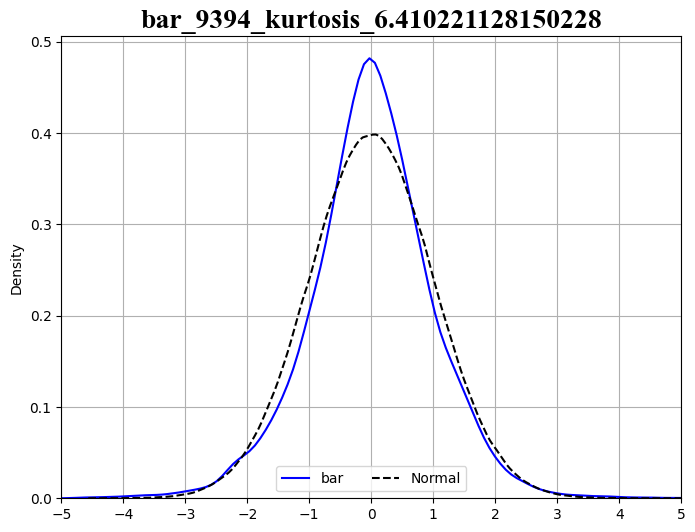

In [10]:
from custom_indicators.utils.plot import plot_kde
from custom_indicators.toolbox.bar.build import build_bar_by_cumsum

assert len(candles[100:]) == len(df)

"""
threshold:
0.7907317146647048
0.916133494307828
"""

merged_bar = build_bar_by_cumsum(
    candles[100:], df["threshold"].tolist(), 0.916133494307828, reverse=False
)

plot_kde(merged_bar[:, 2])

In [12]:
import optuna
from scipy import stats

def objective(trial: optuna.Trial) -> float:
    merge_threshold = trial.suggest_float("merge_threshold", 0.0, 1.0)
    merged_bar = build_bar_by_cumsum(
        candles[100:], df["threshold"].tolist(), merge_threshold, reverse=False
    )
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.HyperbandPruner(),
    sampler=optuna.samplers.TPESampler(),
)
study.optimize(objective, n_trials=100, n_jobs=1)

[I 2025-05-28 23:14:00,303] A new study created in memory with name: no-name-dfa419a5-b5a6-4654-8aef-f2f114d76ffd
[I 2025-05-28 23:14:01,141] Trial 0 finished with value: 10.76020536158673 and parameters: {'merge_threshold': 0.24989561766212098}. Best is trial 0 with value: 10.76020536158673.
[I 2025-05-28 23:14:01,962] Trial 1 finished with value: 7.376626751414728 and parameters: {'merge_threshold': 0.8691228226638732}. Best is trial 1 with value: 7.376626751414728.
[I 2025-05-28 23:14:02,793] Trial 2 finished with value: 6.432706193986712 and parameters: {'merge_threshold': 0.8693532922621539}. Best is trial 2 with value: 6.432706193986712.
[I 2025-05-28 23:14:03,616] Trial 3 finished with value: 8.184323663048705 and parameters: {'merge_threshold': 0.46628600674323484}. Best is trial 2 with value: 6.432706193986712.
[I 2025-05-28 23:14:04,435] Trial 4 finished with value: 8.385452438540868 and parameters: {'merge_threshold': 0.7768783056852469}. Best is trial 2 with value: 6.432706

In [13]:
study.best_params

{'merge_threshold': 0.916133494307828}

In [15]:
# 尝试进一步迭代

def objective(trial: optuna.Trial) -> float:
    candles = np.load("data/btc_1m.npy")
    candles = candles[candles[:, 5] > 0]
    df = numpy_candles_to_dataframe(candles)
    # short log ret
    short_log_n = trial.suggest_int("short_log_n", 5, 50)
    df[f'r{short_log_n}'] = np.log(df['close'] / df['close'].shift(short_log_n))
    # long log ret
    long_log_n = trial.suggest_int("long_log_n", 51, 200)
    df[f'r{long_log_n}'] = np.log(df['close'] / df['close'].shift(long_log_n))
    # entropy
    entropy_n = trial.suggest_int("entropy_n", 30, 100)
    log_ret_list = log_ret(candles, [entropy_n] * len(candles))
    with WorkerPool(n_jobs=os.cpu_count() - 1) as pool:
        entropy_array = pool.map(sample_entropy_numba, log_ret_list)
    len_gap = len(df) - len(entropy_array)
    entropy_array = [np.nan] * len_gap + entropy_array
    df[f'en_{entropy_n}'] = entropy_array

    na_max = df.isna().sum().max()
    df = df.iloc[na_max:]

    df['threshold'] = [min(x, y) for x, y in zip(np.abs(df[f'r{short_log_n}']).tolist(), (df[f'r{long_log_n}'] + df[f'en_{entropy_n}']).tolist())]

    threshold_min = df['threshold'].sum() / (len(candles) // 60)
    threshold_max = df['threshold'].sum() / (len(candles) // 360)
    threshold = trial.suggest_float("threshold", threshold_min, threshold_max)

    len_gap = len(candles) - len(df)
    candles = candles[len_gap:]
    assert len(candles) == len(df), f"{len(candles)} != {len(df)}"
    merged_bar = build_bar_by_cumsum(
        candles, df["threshold"].tolist(), threshold, reverse=False
    )
    close_arr = merged_bar[:, 2]
    ret = np.log(close_arr[1:] / close_arr[:-1])
    standard = (ret - ret.mean()) / ret.std()
    kurtosis = stats.kurtosis(standard, axis=None, fisher=False, nan_policy="omit")
    return kurtosis

study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.NopPruner(),
    sampler=optuna.samplers.TPESampler(n_startup_trials=100),
)
study.optimize(objective, n_trials=1000, n_jobs=1, gc_after_trial=True)

[I 2025-05-28 23:25:44,552] A new study created in memory with name: no-name-b81fe056-e6ae-46ff-a089-f2b1d19033d5
[I 2025-05-28 23:26:42,285] Trial 0 finished with value: 62.22373732368532 and parameters: {'short_log_n': 36, 'long_log_n': 114, 'entropy_n': 94, 'threshold': 0.2541078288837714}. Best is trial 0 with value: 62.22373732368532.
[W 2025-05-28 23:27:11,577] Trial 1 failed with parameters: {'short_log_n': 29, 'long_log_n': 81, 'entropy_n': 100} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/mpire/pool.py", line 762, in imap_unordered
    yield imap_iterator.next(block=True, timeout=0.01)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Caskroom/miniforge/base/envs/jesse/lib/python3.11/site-packages/mpire/async_result.py", line 161, in next
    timed_out = not self._condition.wait(timeout=timeout)
                    ^^^^^^^^

KeyboardInterrupt: 